## Fake News Detection

Individual project in pairs completed by Scott Pan and Federico Loguercio

First a baseline will be fit. In a next step, different models will be fit and varaious iteration taken.

Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk import word_tokenize, WordPunctTokenizer, pos_tag
from nltk.corpus import stopwords
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer, make_column_transformer
import re
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import helpers as hp

Read the data

In [2]:
train = pd.read_csv('../data/fake_or_real_news_training.csv')
# the submission data has no label
submission = pd.read_csv('../data/fake_or_real_news_test.csv')

Set initial values

In [3]:
# These will be used throughout some functions and can be modified easily.
TARGET_VARIABLE = 'label'
METRIC = 'accuracy'
SEED = 123
TIMESERIES = False
SPLITS = 5

First look at data

In [4]:
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


We can see that two extra columns were created, X1 and X2. This is due to the fact that the title is not in quotes such that, if there is a comma in the title, it get's separated at that point and all the other column get shifted. The following cell will take care of that

In [5]:
train = hp.rearrange(train)

In [6]:
train.head()

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


### EDA

Let's see some key distribution metrics of our dataset

Proportion of fake-news:

In [7]:
len(train.loc[train['label'] == 'FAKE'])/len(train)

0.4978744686171543

Explore text length

Text(0.5, 1.0, 'Distribution of Text length')

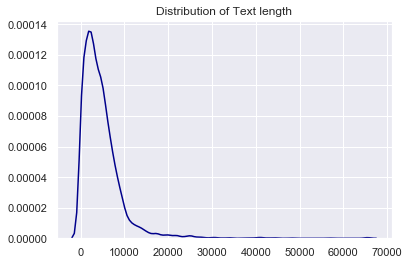

In [8]:
text_len = pd.DataFrame([len(t) for t in train.text])
sns.set()
sns.distplot(text_len, hist = False, color = "darkblue").set_title("Distribution of Text length")

The distribution is highly skewed to the right, there are some very long texts but most lie between 0 and 10000.

How are the quantiles?

### Baseline

Run a baseline without further preprocessing using the countvectorizer. Only the text will be used for now, the title will not be considered yet.

Initiate scores-dataframe that will track scores

In [9]:
all_scores  = pd.DataFrame(columns = ['Model', 'CV Score avg', 'CV Score max', 'Holdout Score'])

Count-vectorize data:

Begin by splitting into train and test set

In [10]:
X_baseline, X_test_baseline, y_baseline, y_test_baseline = train_test_split(train['text'], train['label'],
                                                                            test_size = 0.2, random_state = 7)

In [11]:
# Initiaulize countvectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform 
count_train = count_vectorizer.fit_transform(X_baseline) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test_baseline)

Use Naive Bayes for a first classification

In [12]:
MltNB = MultinomialNB() 

cv_score_baseline, test_score_baseline = hp.cv_evaluate(count_train, y_baseline, count_test, y_test_baseline,
                                                     MltNB)
all_scores = hp.append_scores(all_scores, 'baseline', cv_score_baseline, test_score_baseline)
all_scores

col_0  FAKE  REAL
label            
FAKE    348    57
REAL     27   368


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.895


### Tuning Model
1. Different Model
2. More Process on Data
3. Tuning Parameters
4. Additional thoughts: can we add another model to predicit base on news' title, then ensemble both models to make a final prediction?

TfidfVectorizer instead of CountVectorizer

In [13]:
# can tune max_df later
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, norm='l2')
# transform data
tfidf_train = tfidf_vectorizer.fit_transform(X_baseline)
tfidf_test = tfidf_vectorizer.transform(X_test_baseline)

In [14]:
MltNB_TFIDF = MultinomialNB(alpha=0.1) 

cv_tfidf, test_tfidf = hp.cv_evaluate(tfidf_train, y_baseline, tfidf_test, y_test_baseline,
                                                     MltNB_TFIDF)
all_scores = hp.append_scores(all_scores, 'MltNB TFIDF', cv_tfidf, test_tfidf)
all_scores

col_0  FAKE  REAL
label            
FAKE    347    58
REAL     19   376


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,MltNB TFIDF,0.883704,0.909516,0.90375


### Re-Process Data

Some standard preprocessing will be applied in order to evaluate whether that improves model performance.

In [15]:
# reload data
train_0 = pd.read_csv('../data/fake_or_real_news_training.csv')
train_1 = hp.prepare_data(train_0, tokenize = True)

In [16]:
# split data
def split_data(data, feature='text', random_state = 7):
    X_train, X_test, y_train, y_test = train_test_split(data[feature], data['label'],
                                                        test_size = 0.2, random_state = random_state)
    return X_train, X_test, y_train, y_test

In [17]:
# vectorize
def vectorize_select(selection="tfidf", max_df=0.8, min_df=1, lowercase = True):
    """
    "tfidf":"TfidVectorizer"
    "count":"CountVectorizer"
    "hash":"HashingVectorizer"
    """
    if selection == "tfidf":
        return TfidfVectorizer(stop_words='english', max_df=max_df, min_df=min_df,binary=True,
                              lowercase=lowercase)
    elif selection == "count":
        return CountVectorizer(stop_words='english', max_df=max_df, min_df=min_df)
    elif selection == "hash":
        return HashingVectorizer(stop_words='english')
    else:
        raise Exception("{} can't be found".format(selection))

#### Naive Bayes

With the slightly preprocessed data, let's try different vectorizers (tfidf, count, hash)

In [18]:
# ti-idf vectorize MultinomialNB model
def nb_model(data, selection='tfidf', vectorize_max_df=0.8):
    # split data
    X_train, X_test, y_train, y_test = split_data(data)
    
    # vectorizer: selection: 'tfidf','count','hash'
    vectorizer = vectorize_select(selection, max_df=vectorize_max_df)
    # transform data
    vectorize_train = vectorizer.fit_transform(X_train)
    vectorize_test = vectorizer.transform(X_test)

    # model
    model = MultinomialNB(alpha=0.1)
    cv_scores = cross_val_score(model,
                                vectorize_train,
                                y_train,
                                cv = 5)
    model.fit(vectorize_train, y_train)
    pred = model.predict(vectorize_test)
    acc = accuracy_score(y_test, pred)
    
    #print("accuracy:   %0.3f" % acc)
    print(pd.crosstab(y_test, pred))
    
    return MltNB, cv_scores, acc

In [19]:
MltNB_idf_preproc, cv_scores_idf_preproc, test_score_MltNB_preproc =  nb_model(train_1,'tfidf',0.8)

all_scores = hp.append_scores(all_scores, 'MltNB TFIDF preprocessed', cv_scores_idf_preproc, test_score_MltNB_preproc)
all_scores

col_0    0    1
label          
0      345   60
1       15  380


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,MltNB TFIDF,0.883704,0.909516,0.90375
2,MltNB TFIDF preprocessed,0.884020,0.915757,0.90625


In [20]:
#MltNB_hash_preproc, cv_hash_preproc, test_hash_preproc =  nb_model(train_1,'hash',0.8)

#all_scores = all_scores.append({'Model': 'MltNB hash preprocessed', 'CV Score avg': np.mean(cv_has_preproc), 'CV Score max': np.max(cv_has_preproc), 'Holdout Score': test_hash_preproc}, ignore_index = True)
#all_scores

In [21]:
MltNB_count_preproc, cv_count_preproc, test_count_preproc =  nb_model(train_1,'count',0.8)

all_scores = hp.append_scores(all_scores, 'MltNB count preprocessed', cv_count_preproc, test_count_preproc)
all_scores

col_0    0    1
label          
0      352   53
1       28  367


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,MltNB TFIDF,0.883704,0.909516,0.90375
2,MltNB TFIDF preprocessed,0.884020,0.915757,0.90625
3,MltNB count preprocessed,0.883401,0.903276,0.89875


### Other Models


#### Random Forest

In [22]:
# ti-idf vectorize rf model
def rf_model(data,selection='tfidf',vectorize_max_df=0.8):
    # split data
    X_train, X_test, y_train, y_test = split_data(data)
    
    # vectorizer: selection: 'tfidf','count','hash'
    vectorizer = vectorize_select(selection, max_df=vectorize_max_df)
    # transform data
    vectorize_train = vectorizer.fit_transform(X_train)
    vectorize_test = vectorizer.transform(X_test)
    
    # pipeline
    estimators = [('RF',RandomForestClassifier(random_state=666,n_estimators=100,max_depth=20))]
    pipe = Pipeline(estimators)
    param_RF = {'RF__max_depth': [20,25],
                'RF__n_estimators': [100,150]}
    
    # apply the estimators and parameters in pipeline
    gridPipe = GridSearchCV(pipe, param_RF, cv=5, return_train_score=True)
    model = gridPipe.fit(vectorize_train, y_train)

    pred = model.predict(vectorize_test)
    acc = accuracy_score(y_test, pred)
    
    cv_results = gridPipe.cv_results_['mean_test_score']
    
    #print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))
    
    return model, cv_results, acc

In [23]:
rf_fit, cv_rf, test_rf = rf_model(train_1,'tfidf',0.8)

all_scores = hp.append_scores(all_scores, 'RF tfidf', cv_rf, test_rf)
all_scores

[[367  38]
 [ 41 354]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,MltNB TFIDF,0.883704,0.909516,0.90375
2,MltNB TFIDF preprocessed,0.884020,0.915757,0.90625
3,MltNB count preprocessed,0.883401,0.903276,0.89875
4,RF tfidf,0.854720,0.856518,0.90125


In [24]:
rf_fit_hash, cv_rf_hash, test_rf_hash = rf_model(train_1,'hash',0.8)

all_scores = hp.append_scores(all_scores, 'RF hash', cv_rf_hash, test_rf_hash)
all_scores

[[369  36]
 [ 59 336]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,MltNB TFIDF,0.883704,0.909516,0.90375
2,MltNB TFIDF preprocessed,0.884020,0.915757,0.90625
3,MltNB count preprocessed,0.883401,0.903276,0.89875
4,RF tfidf,0.854720,0.856518,0.90125
5,RF hash,0.825414,0.831510,0.88125


In [25]:
rf_fit_count, cv_rf_count, test_rf_count = rf_model(train_1,'count',0.8)

all_scores = hp.append_scores(all_scores, 'RF count', cv_rf_count, test_rf_count)
all_scores

[[373  32]
 [ 47 348]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,MltNB TFIDF,0.883704,0.909516,0.90375
2,MltNB TFIDF preprocessed,0.884020,0.915757,0.90625
3,MltNB count preprocessed,0.883401,0.903276,0.89875
4,RF tfidf,0.854720,0.856518,0.90125
5,RF hash,0.825414,0.831510,0.88125
6,RF count,0.860425,0.866833,0.90125


#### Passive Aggressive Classifier

In [26]:
def PAC(data, selection='tfidf', vectorize_max_df=0.8, feature='text', lowercase = True):
    # split data
    X_train, X_test, y_train, y_test = split_data(data, feature=feature)
    # vectorizer: selection: 'tfidf','count','hash'
    vectorizer = vectorize_select(selection, max_df=vectorize_max_df, lowercase = lowercase)
    # transform data
    vectorize_train = vectorizer.fit_transform(X_train)
    vectorize_test = vectorizer.transform(X_test)
    # model 
    linear_clf = PassiveAggressiveClassifier(random_state=666, max_iter=100, tol=1e-3,
                                             early_stopping=True, validation_fraction=0.1)
    
    clf_cv_scores = cross_val_score(linear_clf,
                                vectorize_train,
                                y_train,
                                cv = 5)
    linear_clf.fit(vectorize_train, y_train)
    pred = linear_clf.predict(vectorize_test)
    acc = accuracy_score(y_test, pred)
    
    #print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))
    
    return linear_clf, vectorizer, clf_cv_scores, acc

First, use PAC on the text using the different vectorizers:

In [27]:
m_text, v_text, cv_pac_tfidf, test_pac_tfidf = PAC(train_1,'tfidf')

all_scores = hp.append_scores(all_scores, 'PAC tfidf', cv_pac_tfidf, test_pac_tfidf)
all_scores

[[378  27]
 [ 26 369]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,MltNB TFIDF,0.883704,0.909516,0.90375
2,MltNB TFIDF preprocessed,0.884020,0.915757,0.90625
3,MltNB count preprocessed,0.883401,0.903276,0.89875
4,RF tfidf,0.854720,0.856518,0.90125
5,RF hash,0.825414,0.831510,0.88125
6,RF count,0.860425,0.866833,0.90125
7,PAC tfidf,0.927783,0.948518,0.93375


In [28]:
m_hash, v_hash, cv_pac_hash, test_pac_hash = PAC(train_1,'hash')

all_scores = hp.append_scores(all_scores, 'PAC hash', cv_pac_hash, test_pac_hash)
all_scores

[[365  40]
 [ 33 362]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,MltNB TFIDF,0.883704,0.909516,0.90375
2,MltNB TFIDF preprocessed,0.884020,0.915757,0.90625
3,MltNB count preprocessed,0.883401,0.903276,0.89875
4,RF tfidf,0.854720,0.856518,0.90125
5,RF hash,0.825414,0.831510,0.88125
6,RF count,0.860425,0.866833,0.90125
7,PAC tfidf,0.927783,0.948518,0.93375
8,PAC hash,0.917158,0.923557,0.90875


In [29]:
m_count, v_count, cv_pac_count, test_pac_count = PAC(train_1,'count')

all_scores = hp.append_scores(all_scores, 'PAC count', cv_pac_count, test_pac_count)
all_scores

[[346  59]
 [ 46 349]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,MltNB TFIDF,0.883704,0.909516,0.90375
2,MltNB TFIDF preprocessed,0.884020,0.915757,0.90625
3,MltNB count preprocessed,0.883401,0.903276,0.89875
4,RF tfidf,0.854720,0.856518,0.90125
5,RF hash,0.825414,0.831510,0.88125
6,RF count,0.860425,0.866833,0.90125
7,PAC tfidf,0.927783,0.948518,0.93375
8,PAC hash,0.917158,0.923557,0.90875
9,PAC count,0.882466,0.892019,0.86875


### Model on Title

Repeat the same but using the title only:

In [30]:
m_title, v_title, cv_pac_title, test_pac_title = PAC(train_1,'tfidf', feature='title')

all_scores = hp.append_scores(all_scores, 'PAC title count', cv_pac_title, test_pac_title)
all_scores

[[318  87]
 [ 84 311]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,MltNB TFIDF,0.883704,0.909516,0.90375
2,MltNB TFIDF preprocessed,0.884020,0.915757,0.90625
3,MltNB count preprocessed,0.883401,0.903276,0.89875
4,RF tfidf,0.854720,0.856518,0.90125
5,RF hash,0.825414,0.831510,0.88125
6,RF count,0.860425,0.866833,0.90125
7,PAC tfidf,0.927783,0.948518,0.93375
8,PAC hash,0.917158,0.923557,0.90875
9,PAC count,0.882466,0.892019,0.86875


In [31]:
PAC(train_1, 'count', feature='title')

[[309  96]
 [ 84 311]]


(PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
               early_stopping=True, fit_intercept=True, loss='hinge',
               max_iter=100, n_iter=None, n_iter_no_change=5, n_jobs=None,
               random_state=666, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=0.8, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words='english',
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None),
 array([0.7800312 , 0.75625   , 0.753125  , 0.76525822, 0.77621283]),
 0.775)

In [32]:
PAC(train_1, 'hash', feature='title')

[[318  87]
 [ 82 313]]


(PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
               early_stopping=True, fit_intercept=True, loss='hinge',
               max_iter=100, n_iter=None, n_iter_no_change=5, n_jobs=None,
               random_state=666, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
          decode_error='strict', dtype=<class 'numpy.float64'>,
          encoding='utf-8', input='content', lowercase=True,
          n_features=1048576, ngram_range=(1, 1), non_negative=False,
          norm='l2', preprocessor=None, stop_words='english',
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None),
 array([0.78783151, 0.7578125 , 0.76875   , 0.77934272, 0.78090767]),
 0.78875)

And now combine the best predictions from text and title:

1. predict base on text (train on training set, predict on the entire)
2. predict base on title (train on training set, predict on the entire)
3. add two predictions to the dataframe
4. maybe concatenate title and text?

In [33]:
# adding text based prediction to data
data_text = v_text.transform(train_1.text)
data_text_prediction = m_text.predict(data_text)
train_1['text_predict'] = data_text_prediction

In [34]:
# adding title based prediction to data
data_title = v_title.transform(train_1.title)
data_title_prediction = m_title.predict(data_title)
train_1['title_predict'] = data_title_prediction

#### Further Process Data

Create a dataframe containing several other features as well as the predictions from text and title and predict using that dataframe

In [35]:
train_2 = hp.preprocess_data(train_1, drop_unprocessed = False)
train_3 = train_2[['label','text_predict','title_predict','trump_title', 'trump_text',
                   'title_NN_count', 'title_VERB_count','title_ADJ_count', 
                   'text_NN_count', 'text_VERB_count','text_ADJ_count', 
                   'title_length', 'text_length']]

In [36]:
# ti-idf vectorize rf model
def rf_model_2(data,features):
    # split data
    X_train, X_test, y_train, y_test = split_data(data,feature=features)
    
    # pipeline
    estimators = [('RF',RandomForestClassifier(random_state=666))]
    pipe = Pipeline(estimators)
    param_RF = {'RF__max_depth': [20,25],
                'RF__n_estimators': [150,200]}
    
    # apply the estimators and parameters in pipeline
    gridPipe = GridSearchCV(pipe, param_RF, cv=5, return_train_score=True)
    model = gridPipe.fit(X_train, y_train)

    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))

    return model

In [37]:
features = ['text_predict','title_predict',
            'trump_title', 'trump_text',
#             'title_NN_count', 'title_VERB_count','title_ADJ_count', 
#             'text_NN_count', 'text_VERB_count','text_ADJ_count', 
#             'title_length', 'text_length'
           ]
m = rf_model_2(train_3,features)

accuracy:   0.934
[[378  27]
 [ 26 369]]


In [48]:
porter=PorterStemmer()
def stemSentence(sentence):
    token_words=word_tokenize(sentence.lower())
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [49]:
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

lemmatizer = WordNetLemmatizer()
def lemma(text):    
    tagged_sentence = pos_tag(word_tokenize(text))
    lemm = [lemmatizer.lemmatize(word, pos=penn_to_wn(tag)) for word, tag in tagged_sentence if penn_to_wn(tag) != None ]
    return " ".join(lemm)

In [40]:
# reprepare data
train_2 = hp.prepare_data(train_0)

In [41]:
train_2.head()

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [43]:
m_pac_lowercase, v_pac_not_lowercase, cv_pac_not_lowercase, test_pac_not_lowercase = PAC(train_2,feature='text', lowercase = False)

all_scores = hp.append_scores(all_scores, 'PAC tfidf not lowercase', cv_pac_not_lowercase, test_pac_not_lowercase)
all_scores

[[385  20]
 [ 15 380]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,MltNB TFIDF,0.883704,0.909516,0.90375
2,MltNB TFIDF preprocessed,0.884020,0.915757,0.90625
3,MltNB count preprocessed,0.883401,0.903276,0.89875
4,RF tfidf,0.854720,0.856518,0.90125
5,RF hash,0.825414,0.831510,0.88125
6,RF count,0.860425,0.866833,0.90125
7,PAC tfidf,0.927783,0.948518,0.93375
8,PAC hash,0.917158,0.923557,0.90875
9,PAC count,0.882466,0.892019,0.86875


In [44]:
# passive aggressive classifier with grid search cv
def PAC_T(data, selection='tfidf', vectorize_max_df=0.8, vectorize_min_df=1, feature='text'):
    # split data
    X_train, X_test, y_train, y_test = split_data(data, feature=feature, random_state=666)
    estimators = [   
                    ('TF',TfidfVectorizer(stop_words='english', binary=True, lowercase=False,
                                          max_df=vectorize_max_df, min_df=vectorize_min_df,
                                         norm='l2',sublinear_tf=False)
                    ),
                    ('PA',PassiveAggressiveClassifier(random_state=666, max_iter=1000, 
                                                      n_iter_no_change=10, tol=1e-3, 
                                                      early_stopping=True, loss='squared_hinge',
                                                      fit_intercept= False,
                                                      validation_fraction=0.1))
                ]
    pipe = Pipeline(estimators)
    param_RF = {
                'PA__C': [1]
                }
    
    # apply the estimators and parameters in pipeline
    gridPipe = GridSearchCV(pipe, param_RF, cv=5, return_train_score=True)
    model = gridPipe.fit(X_train, y_train)

    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    cv_results = gridPipe.cv_results_['mean_test_score']
    print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))
    
    return model, cv_results, acc

In [45]:
PAC_T, cv_pact, test_pact = PAC_T(train_2,feature='text')

all_scores = hp.append_scores(all_scores, 'PAC tuned', cv_pact, test_pact)
all_scores

accuracy:   0.943
[[375  24]
 [ 22 379]]


,Model,CV Score avg,CV Score max,Holdout Score
0,baseline,0.877145,0.900156,0.89500
1,MltNB TFIDF,0.883704,0.909516,0.90375
2,MltNB TFIDF preprocessed,0.884020,0.915757,0.90625
3,MltNB count preprocessed,0.883401,0.903276,0.89875
4,RF tfidf,0.854720,0.856518,0.90125
5,RF hash,0.825414,0.831510,0.88125
6,RF count,0.860425,0.866833,0.90125
7,PAC tfidf,0.927783,0.948518,0.93375
8,PAC hash,0.917158,0.923557,0.90875
9,PAC count,0.882466,0.892019,0.86875


In [33]:
# passive aggressive classifier with grid search cv
def PAC_NGRAM(data, selection='tfidf', feature='text'):
    # split data
    X_train, X_test, y_train, y_test = split_data(data, feature=feature, random_state=666)
    estimators = [   
                    ('TF',TfidfVectorizer(stop_words='english', binary=True, lowercase=False,
                                          max_df=0.8,
                                         norm='l2',sublinear_tf=False)
                    ),
                    ('PA',PassiveAggressiveClassifier(random_state=666, max_iter=1000, 
                                                      n_iter_no_change=10, tol=1e-3, 
                                                      early_stopping=True, loss='squared_hinge',
                                                      fit_intercept= False,
                                                      validation_fraction=0.1))
                ]
    pipe = Pipeline(estimators)
    param_RF = {
                'TF__min_df':[1,2,3,4],
                'TF__ngram_range': [(1,1),(1,2),(1,3),(1,4)]
                }
    
    # apply the estimators and parameters in pipeline
    gridPipe = GridSearchCV(pipe, param_RF, cv=5, return_train_score=True)
    model = gridPipe.fit(X_train, y_train)

    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc)
    print(confusion_matrix(y_test, pred, labels=[0, 1]))
    
    return model

In [ ]:
# in the preprocess function I created new column "text_edit" which removes \n and includes date information
# to use "text_edit", just set feature='text_edit' in the model 👇
PAC_N, cv_pact, test_pact = PAC_NGRAM(train_2,feature='text')

all_scores = hp.append_scores(all_scores, 'PAC NGRAM MIN_DF', cv_pact, test_pact)
all_scores

## Final Submission

Retrain the best model on the entire data and predict on the submission set

In [47]:
# passive aggressive classifier with grid search cv
def PAC_FINAL(data, selection='tfidf', vectorize_max_df=0.8, vectorize_min_df=1, feature='text'):
    # split data
    X_train = data['text']
    y_train = data['label']
    estimators = [   
                    ('TF',TfidfVectorizer(stop_words='english', binary=True, lowercase=False,
                                          max_df=vectorize_max_df, min_df=vectorize_min_df,
                                         norm='l2',sublinear_tf=False)
                    ),
                    ('PA',PassiveAggressiveClassifier(random_state=666, max_iter=1000, 
                                                      n_iter_no_change=10, tol=1e-3, 
                                                      early_stopping=True, loss='squared_hinge',
                                                      fit_intercept= False,
                                                      validation_fraction=0.1))
                ]
    pipe = Pipeline(estimators)
    param_RF = {
                'PA__C': [1]
                }
    
    # apply the estimators and parameters in pipeline
    gridPipe = GridSearchCV(pipe, param_RF, cv=5, return_train_score=True)
    model = gridPipe.fit(X_train, y_train)

#     pred = model.predict(X_test)
#     acc = accuracy_score(y_test, pred)
#     cv_results = gridPipe.cv_results_['mean_test_score']
#     print("accuracy:   %0.3f" % acc)
#     print(confusion_matrix(y_test, pred, labels=[0, 1]))
    
    return model

In [48]:
m2 = PAC_FINAL(train_2,feature='text')

In [49]:
# Slight modifications to the preparation-function
# because the submission data has a slightly different structure

# m2 is the model from the PAC function
# to apply the same process on submiss
submission['prediction'] = m2.predict(submission['text'])
submission.prediction[submission.prediction==0] = 'FAKE'
submission.prediction[submission.prediction==1] = 'REAL'
submission = submission.set_index('ID')

# answer is the dataset from kaggle
# this is the dataset downloaded from kaggle so I didn't put it inside the repo
answer = pd.read_csv('../../fake_or_real_news.csv')
answer.rename(columns={'Unnamed: 0':'ID'}, inplace=True)
answer = answer.set_index('ID')

# left join on submission with prediction
submission2 = submission.join(answer[['label']],how='left')

# metrics
acc = accuracy_score(submission2.label, submission2.prediction)
print("accuracy:   %0.3f" % acc)
print(confusion_matrix(submission2.label, submission2.prediction, labels=['FAKE', 'REAL']))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


accuracy:   0.947
[[1088   76]
 [  48 1109]]
